In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [113]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN, evaluate_fnn
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_results, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths, by_ref
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from time import time
from torch.optim import lr_scheduler


In [95]:
data_sub_paths = get_data_sub_paths()
print(np.sort(data_sub_paths))

['T12H-X850M-Y880M_2013-01-01_2017-01-01'
 'T1H-X1700M-Y1760M_2013-01-01_2017-01-01'
 'T1H-X3400M-Y3520M_2014-01-01_2016-01-01_#2a4'
 'T24H-X1275M-Y1320M_2012-01-01_2019-01-01'
 'T24H-X1700M-Y1760M_2012-01-01_2019-01-01'
 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97'
 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#d97'
 'T24H-X255M-Y220M_2013-01-01_2017-01-01'
 'T24H-X255M-Y220M_2014-01-01_2019-01-01_#b29'
 'T24H-X425M-Y440M_2012-01-01_2019-01-01'
 'T24H-X425M-Y440M_2013-01-01_2017-01-01'
 'T24H-X850M-Y880M_2012-01-01_2019-01-01'
 'T24H-X850M-Y880M_2013-01-01_2017-01-01'
 'T24H-X850M-Y880M_2014-01-01_2019-01-01_#1a0'
 'T24H-X850M-Y880M_2014-01-01_2019-01-01_#3a0'
 'T24H-X85M-Y110M_2013-01-01_2017-01-01'
 'T3H-X850M-Y880M_2013-01-01_2017-01-01'
 'T6H-X850M-Y880M_2013-01-01_2017-01-01']


In [96]:
data_sub_paths = by_ref("c97")
data_sub_paths

['T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97']

In [97]:
from pprint import pprint
conf = BaseConf()

In [98]:
pprint(conf)

{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': '',
 'device': None,
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'lr': 0.001,
 'max_epochs': 1,
 'model_name': '',
 'model_path': '',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'pad_width': 0,
 'patience': 10,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': True,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 1,
 'sub_sample_validation_set': 1,
 'timer': <utils.utils.Timer object at 0x7fe162de58e0>,
 'tolerance': 1e-08,
 'tst_ratio': 0.25,
 'use_classification': True,
 'use_crime_types': False,
 'use_historic_average': True,
 'use_seq_loss': True,
 'val_ratio': 0.25,
 'weight_decay': 1e-08}


2020-09-29T15:52:56 | root | INFO | 
                                RMSE       MAE   ROC AUC  Avg. Precision  \
Model Name                                                                 
SimpleKangFNN_best_trn_val  0.604996  0.366627  0.825536        0.471703   
ST-RESNET                   0.353654  0.126232  0.820416        0.470513   
Historic Average            0.352860  0.125658  0.824147        0.468529   
Ind-Hawkes Model            0.382821  0.147177  0.824078        0.467860   
Global Average              0.352786  0.125609  0.822889        0.466622   
Previous Time Step          0.353081  0.125817  0.612782        0.223152   

                            Precision    Recall  F1 Score  Accuracy       MCC  \
Model Name                                                                      
SimpleKangFNN_best_trn_val   0.380648  0.548314  0.449350  0.838810  0.364843   
ST-RESNET                    0.406699  0.492086  0.445336  0.855018  0.363372   
Historic Average             0

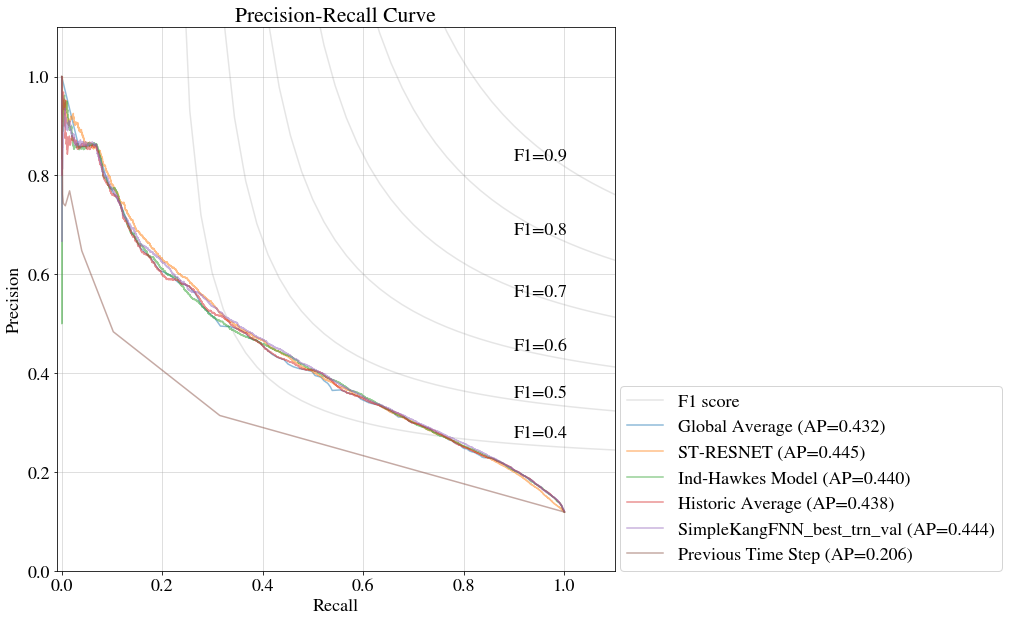

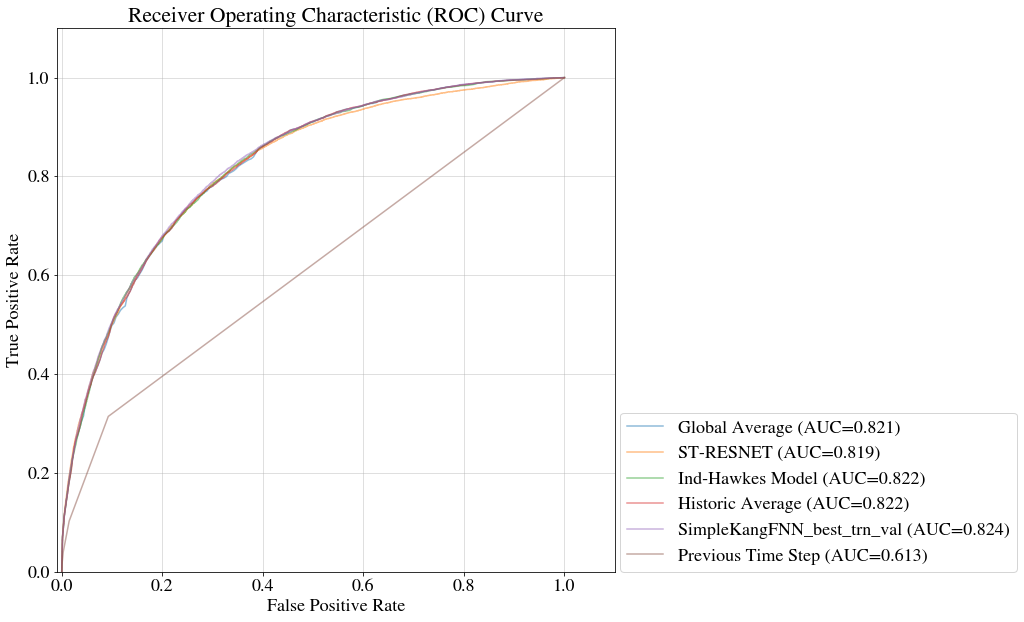

2020-09-29T15:52:56 | root | INFO | =====================================BEGIN=====================================
2020-09-29T15:52:56 | root | INFO | Device: cpu


In [99]:
# T24H-X850M-Y880M_2012-01-01_2019-01-01

data_sub_path = data_sub_paths[0]

# manually set
conf = BaseConf()
conf.seed = int(time()) # 3
conf.model_name = "SimpleKangFNN" # "KangFNN"  # needs to be created
conf.data_path = f"./data/processed/{data_sub_path}/"

compare_all_models(data_path=conf.data_path)

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

In [100]:
log.getLogger().setLevel("INFO")

In [101]:
# SET THE HYPER PARAMETERS
conf.resume = True
conf.early_stopping = False
conf.patience = 80
conf.max_epochs = 300
conf.dropout = 0.05
conf.weight_decay = 1e-8  # [0, 1e-8, 1e-6, 1e-4, 1e-2]
conf.checkpoint = "latest" # ["best_val", "best_trn", "best_trn_val"]
conf.lr = 1e-3
conf.shaper_top_k = -1
conf.batch_size = 256


MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA
    conf.sub_sample_test_set = 0
    conf.sub_sample_train_set = 1
    conf.sub_sample_validation_set = 1

    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.CrossEntropyLoss()  

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]



if conf.model_name == "SimpleKangFNN":
    model_arch = {
        "h_size0": 10,
        "h_size1": 10,
        "h_size2": 10,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                         tmp_size=tmp_size,
                         env_size=env_size,
                         dropout_p=conf.dropout,
                         model_arch=model_arch)
else:
    model_arch = {
        "scp_net_h0": 64,
        "scp_net_h1": 32,
        "tmp_net_h0": 64,
        "tmp_net_h1": 32,
        "env_net_h0": 64,
        "env_net_h1": 32,
        "final_net_h1": 64,
    }
    model = KangFeedForwardNetwork(spc_size=spc_size,
                                     tmp_size=tmp_size,
                                     env_size=env_size,
                                     dropout_p=conf.dropout,
                                     model_arch=model_arch)

model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay, amsgrad=True)
# optimiser = optim.SGD(params=parameters, lr=conf.lr)
scheduler = None
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimiser, T_max=10)#conf.max_epochs//5)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10,
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0,
#                                            min_lr=0, eps=1e-08, verbose=False)


##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

2020-09-29T15:52:58 | root | INFO | loading crimes grids WITHOUT crime types
2020-09-29T15:52:58 | root | INFO | 	t_range: (2558,) 2012-01-01 00:00:00 -> 2019-01-01 00:00:00
2020-09-29T15:52:58 | root | INFO | 	target_len:	2191	(100.000%)
2020-09-29T15:52:58 | root | INFO | 	trn_val_size:	1826	(83.341%)
2020-09-29T15:52:58 | root | INFO | 	trn_size:	1370	(62.529%)
2020-09-29T15:52:58 | root | INFO | 	val_size:	456	(20.812%)
2020-09-29T15:52:58 | root | INFO | 	tst_size:	365 	(16.659%)
fitted historic average: step (1) and max_steps (-1)


2020-09-29T15:53:00 | root | INFO | 
 ====================== Training SimpleKangFNN ====================== 

2020-09-29T15:53:00 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 256,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/',
 'device': device(type='cpu'),
 'dropout': 0.05,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 300,
 'model_name': 'SimpleKangFNN',
 'model_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/models/SimpleKangFNN/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'pad_width': 0,
 'patience': 80,
 'resume': True,
 'seed': 1601387576,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': True,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 1,
 'sub_sample_validation_set': 1,
 'timer': <utils.utils.Timer object at 0x7

2020-09-29T15:53:27 | root | INFO | Epoch: 0014/0300
2020-09-29T15:53:30 | root | INFO | 	Loss (Trn): 		0.52573121
2020-09-29T15:53:30 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:53:30 | root | INFO | 	Loss (Val): 		0.52942978
2020-09-29T15:53:30 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:53:30 | root | INFO | 	Loss (Trn Val): 	1.05516099
2020-09-29T15:53:30 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:53:30 | root | INFO | 	Loss (Trn Val Dif): 	0.00369857

2020-09-29T15:53:30 | root | INFO | Epoch: 0015/0300
2020-09-29T15:53:32 | root | INFO | 	Loss (Trn): 		0.52547578
2020-09-29T15:53:32 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:53:32 | root | INFO | 	Loss (Val): 		0.52925423
2020-09-29T15:53:32 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:53:32 | root | INFO | 	Loss (Trn Val): 	1.05473001
2020-09-29T15:53:32 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:53:32 | root | INFO | 	Loss 

2020-09-29T15:54:04 | root | INFO | Epoch: 0030/0300
2020-09-29T15:54:06 | root | INFO | 	Loss (Trn): 		0.52594116
2020-09-29T15:54:06 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:54:06 | root | INFO | 	Loss (Val): 		0.52851371
2020-09-29T15:54:06 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:54:06 | root | INFO | 	Loss (Trn Val): 	1.05445488
2020-09-29T15:54:06 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:54:06 | root | INFO | 	Loss (Trn Val Dif): 	0.00257255

2020-09-29T15:54:07 | root | INFO | Epoch: 0031/0300
2020-09-29T15:54:09 | root | INFO | 	Loss (Trn): 		0.52577067
2020-09-29T15:54:09 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:54:09 | root | INFO | 	Loss (Val): 		0.52813270
2020-09-29T15:54:09 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:54:09 | root | INFO | 	Loss (Trn Val): 	1.05390337
2020-09-29T15:54:09 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:54:09 | root | INFO | 	Loss 

2020-09-29T15:54:41 | root | INFO | Epoch: 0046/0300
2020-09-29T15:54:43 | root | INFO | 	Loss (Trn): 		0.52517266
2020-09-29T15:54:43 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:54:43 | root | INFO | 	Loss (Val): 		0.52882219
2020-09-29T15:54:43 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:54:43 | root | INFO | 	Loss (Trn Val): 	1.05399485
2020-09-29T15:54:43 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:54:43 | root | INFO | 	Loss (Trn Val Dif): 	0.00364953

2020-09-29T15:54:43 | root | INFO | Epoch: 0047/0300
2020-09-29T15:54:46 | root | INFO | 	Loss (Trn): 		0.52479229
2020-09-29T15:54:46 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:54:46 | root | INFO | 	Loss (Val): 		0.52927532
2020-09-29T15:54:46 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:54:46 | root | INFO | 	Loss (Trn Val): 	1.05406760
2020-09-29T15:54:46 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:54:46 | root | INFO | 	Loss 

2020-09-29T15:55:17 | root | INFO | Epoch: 0062/0300
2020-09-29T15:55:20 | root | INFO | 	Loss (Trn): 		0.52339116
2020-09-29T15:55:20 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:55:20 | root | INFO | 	Loss (Val): 		0.52945845
2020-09-29T15:55:20 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:55:20 | root | INFO | 	Loss (Trn Val): 	1.05284961
2020-09-29T15:55:20 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:55:20 | root | INFO | 	Loss (Trn Val Dif): 	0.00606729

2020-09-29T15:55:20 | root | INFO | Epoch: 0063/0300
2020-09-29T15:55:22 | root | INFO | 	Loss (Trn): 		0.52429959
2020-09-29T15:55:22 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:55:22 | root | INFO | 	Loss (Val): 		0.53097218
2020-09-29T15:55:22 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:55:22 | root | INFO | 	Loss (Trn Val): 	1.05527177
2020-09-29T15:55:22 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:55:22 | root | INFO | 	Loss 

2020-09-29T15:55:55 | root | INFO | Epoch: 0078/0300
2020-09-29T15:55:57 | root | INFO | 	Loss (Trn): 		0.52420622
2020-09-29T15:55:57 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:55:57 | root | INFO | 	Loss (Val): 		0.52987508
2020-09-29T15:55:57 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:55:57 | root | INFO | 	Loss (Trn Val): 	1.05408130
2020-09-29T15:55:57 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:55:57 | root | INFO | 	Loss (Trn Val Dif): 	0.00566887

2020-09-29T15:55:57 | root | INFO | Epoch: 0079/0300
2020-09-29T15:56:00 | root | INFO | 	Loss (Trn): 		0.52456673
2020-09-29T15:56:00 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:56:00 | root | INFO | 	Loss (Val): 		0.52924597
2020-09-29T15:56:00 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:56:00 | root | INFO | 	Loss (Trn Val): 	1.05381270
2020-09-29T15:56:00 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:56:00 | root | INFO | 	Loss 

2020-09-29T15:56:33 | root | INFO | Epoch: 0094/0300
2020-09-29T15:56:35 | root | INFO | 	Loss (Trn): 		0.52453121
2020-09-29T15:56:35 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:56:35 | root | INFO | 	Loss (Val): 		0.53048488
2020-09-29T15:56:35 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:56:35 | root | INFO | 	Loss (Trn Val): 	1.05501609
2020-09-29T15:56:35 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:56:35 | root | INFO | 	Loss (Trn Val Dif): 	0.00595367

2020-09-29T15:56:35 | root | INFO | Epoch: 0095/0300
2020-09-29T15:56:37 | root | INFO | 	Loss (Trn): 		0.52428968
2020-09-29T15:56:37 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:56:37 | root | INFO | 	Loss (Val): 		0.53041880
2020-09-29T15:56:37 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:56:37 | root | INFO | 	Loss (Trn Val): 	1.05470847
2020-09-29T15:56:37 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:56:37 | root | INFO | 	Loss 

2020-09-29T15:57:13 | root | INFO | Epoch: 0110/0300
2020-09-29T15:57:16 | root | INFO | 	Loss (Trn): 		0.52420983
2020-09-29T15:57:16 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:57:16 | root | INFO | 	Loss (Val): 		0.52904647
2020-09-29T15:57:16 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:57:16 | root | INFO | 	Loss (Trn Val): 	1.05325630
2020-09-29T15:57:16 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:57:16 | root | INFO | 	Loss (Trn Val Dif): 	0.00483664

2020-09-29T15:57:16 | root | INFO | Epoch: 0111/0300
2020-09-29T15:57:19 | root | INFO | 	Loss (Trn): 		0.52288048
2020-09-29T15:57:19 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:57:19 | root | INFO | 	Loss (Val): 		0.52914103
2020-09-29T15:57:19 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:57:19 | root | INFO | 	Loss (Trn Val): 	1.05202151
2020-09-29T15:57:19 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:57:19 | root | INFO | 	Loss 

2020-09-29T15:57:52 | root | INFO | Epoch: 0126/0300
2020-09-29T15:57:54 | root | INFO | 	Loss (Trn): 		0.52425430
2020-09-29T15:57:54 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:57:54 | root | INFO | 	Loss (Val): 		0.52890889
2020-09-29T15:57:54 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:57:54 | root | INFO | 	Loss (Trn Val): 	1.05316319
2020-09-29T15:57:54 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:57:54 | root | INFO | 	Loss (Trn Val Dif): 	0.00465459

2020-09-29T15:57:54 | root | INFO | Epoch: 0127/0300
2020-09-29T15:57:57 | root | INFO | 	Loss (Trn): 		0.52305285
2020-09-29T15:57:57 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:57:57 | root | INFO | 	Loss (Val): 		0.53081148
2020-09-29T15:57:57 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:57:57 | root | INFO | 	Loss (Trn Val): 	1.05386433
2020-09-29T15:57:57 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:57:57 | root | INFO | 	Loss 

2020-09-29T15:58:30 | root | INFO | Epoch: 0142/0300
2020-09-29T15:58:33 | root | INFO | 	Loss (Trn): 		0.52326334
2020-09-29T15:58:33 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:58:33 | root | INFO | 	Loss (Val): 		0.53072451
2020-09-29T15:58:33 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:58:33 | root | INFO | 	Loss (Trn Val): 	1.05398785
2020-09-29T15:58:33 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:58:33 | root | INFO | 	Loss (Trn Val Dif): 	0.00746118

2020-09-29T15:58:33 | root | INFO | Epoch: 0143/0300
2020-09-29T15:58:35 | root | INFO | 	Loss (Trn): 		0.52355026
2020-09-29T15:58:35 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:58:35 | root | INFO | 	Loss (Val): 		0.52938137
2020-09-29T15:58:35 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:58:35 | root | INFO | 	Loss (Trn Val): 	1.05293163
2020-09-29T15:58:35 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:58:35 | root | INFO | 	Loss 

2020-09-29T15:59:08 | root | INFO | Epoch: 0158/0300
2020-09-29T15:59:11 | root | INFO | 	Loss (Trn): 		0.52241389
2020-09-29T15:59:11 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:59:11 | root | INFO | 	Loss (Val): 		0.52920652
2020-09-29T15:59:11 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:59:11 | root | INFO | 	Loss (Trn Val): 	1.05162041
2020-09-29T15:59:11 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:59:11 | root | INFO | 	Loss (Trn Val Dif): 	0.00679263

2020-09-29T15:59:11 | root | INFO | Epoch: 0159/0300
2020-09-29T15:59:13 | root | INFO | 	Loss (Trn): 		0.52266163
2020-09-29T15:59:13 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:59:13 | root | INFO | 	Loss (Val): 		0.52864768
2020-09-29T15:59:13 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:59:13 | root | INFO | 	Loss (Trn Val): 	1.05130932
2020-09-29T15:59:13 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:59:13 | root | INFO | 	Loss 

2020-09-29T15:59:46 | root | INFO | Epoch: 0174/0300
2020-09-29T15:59:49 | root | INFO | 	Loss (Trn): 		0.52265446
2020-09-29T15:59:49 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:59:49 | root | INFO | 	Loss (Val): 		0.53065738
2020-09-29T15:59:49 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:59:49 | root | INFO | 	Loss (Trn Val): 	1.05331184
2020-09-29T15:59:49 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:59:49 | root | INFO | 	Loss (Trn Val Dif): 	0.00800292

2020-09-29T15:59:49 | root | INFO | Epoch: 0175/0300
2020-09-29T15:59:51 | root | INFO | 	Loss (Trn): 		0.52285487
2020-09-29T15:59:51 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T15:59:51 | root | INFO | 	Loss (Val): 		0.52904804
2020-09-29T15:59:51 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T15:59:51 | root | INFO | 	Loss (Trn Val): 	1.05190291
2020-09-29T15:59:51 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T15:59:51 | root | INFO | 	Loss 

2020-09-29T16:00:25 | root | INFO | Epoch: 0190/0300
2020-09-29T16:00:28 | root | INFO | 	Loss (Trn): 		0.52224944
2020-09-29T16:00:28 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:00:28 | root | INFO | 	Loss (Val): 		0.53029756
2020-09-29T16:00:28 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:00:28 | root | INFO | 	Loss (Trn Val): 	1.05254700
2020-09-29T16:00:28 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:00:28 | root | INFO | 	Loss (Trn Val Dif): 	0.00804812

2020-09-29T16:00:28 | root | INFO | Epoch: 0191/0300
2020-09-29T16:00:30 | root | INFO | 	Loss (Trn): 		0.52167359
2020-09-29T16:00:30 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:00:30 | root | INFO | 	Loss (Val): 		0.52919935
2020-09-29T16:00:30 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:00:30 | root | INFO | 	Loss (Trn Val): 	1.05087294
2020-09-29T16:00:30 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:00:30 | root | INFO | 	Loss 

2020-09-29T16:01:04 | root | INFO | Epoch: 0206/0300
2020-09-29T16:01:07 | root | INFO | 	Loss (Trn): 		0.52294752
2020-09-29T16:01:07 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:01:07 | root | INFO | 	Loss (Val): 		0.52863212
2020-09-29T16:01:07 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:01:07 | root | INFO | 	Loss (Trn Val): 	1.05157965
2020-09-29T16:01:07 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:01:07 | root | INFO | 	Loss (Trn Val Dif): 	0.00568460

2020-09-29T16:01:07 | root | INFO | Epoch: 0207/0300
2020-09-29T16:01:09 | root | INFO | 	Loss (Trn): 		0.52201809
2020-09-29T16:01:09 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:01:09 | root | INFO | 	Loss (Val): 		0.53042986
2020-09-29T16:01:09 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:01:09 | root | INFO | 	Loss (Trn Val): 	1.05244795
2020-09-29T16:01:09 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:01:09 | root | INFO | 	Loss 

2020-09-29T16:01:43 | root | INFO | Epoch: 0222/0300
2020-09-29T16:01:46 | root | INFO | 	Loss (Trn): 		0.52156574
2020-09-29T16:01:46 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:01:46 | root | INFO | 	Loss (Val): 		0.52835116
2020-09-29T16:01:46 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:01:46 | root | INFO | 	Loss (Trn Val): 	1.04991690
2020-09-29T16:01:46 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:01:46 | root | INFO | 	Loss (Trn Val Dif): 	0.00678542

2020-09-29T16:01:46 | root | INFO | Epoch: 0223/0300
2020-09-29T16:01:48 | root | INFO | 	Loss (Trn): 		0.52206868
2020-09-29T16:01:48 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:01:48 | root | INFO | 	Loss (Val): 		0.53119271
2020-09-29T16:01:48 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:01:48 | root | INFO | 	Loss (Trn Val): 	1.05326139
2020-09-29T16:01:48 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:01:48 | root | INFO | 	Loss 

2020-09-29T16:02:23 | root | INFO | Epoch: 0238/0300
2020-09-29T16:02:26 | root | INFO | 	Loss (Trn): 		0.52179567
2020-09-29T16:02:26 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:02:26 | root | INFO | 	Loss (Val): 		0.52810126
2020-09-29T16:02:26 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:02:26 | root | INFO | 	Loss (Trn Val): 	1.04989693
2020-09-29T16:02:26 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:02:26 | root | INFO | 	Loss (Trn Val Dif): 	0.00630560

2020-09-29T16:02:26 | root | INFO | Epoch: 0239/0300
2020-09-29T16:02:28 | root | INFO | 	Loss (Trn): 		0.52185056
2020-09-29T16:02:28 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:02:28 | root | INFO | 	Loss (Val): 		0.52923383
2020-09-29T16:02:28 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:02:28 | root | INFO | 	Loss (Trn Val): 	1.05108439
2020-09-29T16:02:28 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:02:28 | root | INFO | 	Loss 

2020-09-29T16:03:04 | root | INFO | Epoch: 0254/0300
2020-09-29T16:03:06 | root | INFO | 	Loss (Trn): 		0.52278069
2020-09-29T16:03:06 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:03:06 | root | INFO | 	Loss (Val): 		0.53138197
2020-09-29T16:03:06 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:03:06 | root | INFO | 	Loss (Trn Val): 	1.05416266
2020-09-29T16:03:06 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:03:06 | root | INFO | 	Loss (Trn Val Dif): 	0.00860127

2020-09-29T16:03:06 | root | INFO | Epoch: 0255/0300
2020-09-29T16:03:08 | root | INFO | 	Loss (Trn): 		0.52164842
2020-09-29T16:03:08 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:03:08 | root | INFO | 	Loss (Val): 		0.52880860
2020-09-29T16:03:08 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:03:08 | root | INFO | 	Loss (Trn Val): 	1.05045703
2020-09-29T16:03:08 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:03:08 | root | INFO | 	Loss 

2020-09-29T16:03:43 | root | INFO | Epoch: 0270/0300
2020-09-29T16:03:45 | root | INFO | 	Loss (Trn): 		0.52261364
2020-09-29T16:03:45 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:03:45 | root | INFO | 	Loss (Val): 		0.52798511
2020-09-29T16:03:45 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:03:45 | root | INFO | 	Loss (Trn Val): 	1.05059874
2020-09-29T16:03:45 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:03:45 | root | INFO | 	Loss (Trn Val Dif): 	0.00537147

2020-09-29T16:03:45 | root | INFO | Epoch: 0271/0300
2020-09-29T16:03:47 | root | INFO | 	Loss (Trn): 		0.52170777
2020-09-29T16:03:47 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:03:47 | root | INFO | 	Loss (Val): 		0.52903582
2020-09-29T16:03:47 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:03:47 | root | INFO | 	Loss (Trn Val): 	1.05074359
2020-09-29T16:03:47 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:03:47 | root | INFO | 	Loss 

2020-09-29T16:04:24 | root | INFO | Epoch: 0286/0300
2020-09-29T16:04:26 | root | INFO | 	Loss (Trn): 		0.52225670
2020-09-29T16:04:26 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:04:26 | root | INFO | 	Loss (Val): 		0.52943519
2020-09-29T16:04:26 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:04:26 | root | INFO | 	Loss (Trn Val): 	1.05169189
2020-09-29T16:04:26 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:04:26 | root | INFO | 	Loss (Trn Val Dif): 	0.00717849

2020-09-29T16:04:26 | root | INFO | Epoch: 0287/0300
2020-09-29T16:04:29 | root | INFO | 	Loss (Trn): 		0.52092407
2020-09-29T16:04:29 | root | INFO | 	Loss (Best Trn): 	0.51893508
2020-09-29T16:04:29 | root | INFO | 	Loss (Val): 		0.53043855
2020-09-29T16:04:29 | root | INFO | 	Loss (Best Val): 	0.52602581
2020-09-29T16:04:29 | root | INFO | 	Loss (Trn Val): 	1.05136262
2020-09-29T16:04:29 | root | INFO | 	Loss (Best Trn Val): 	1.04619021
2020-09-29T16:04:29 | root | INFO | 	Loss 

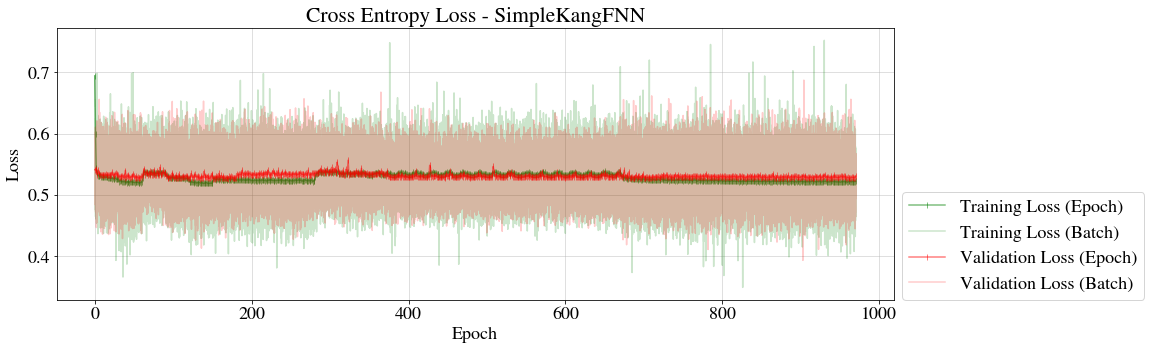

In [102]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_fnn,
    loss_fn=loss_function,
    conf=conf,
    scheduler=scheduler,
)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [103]:
from utils.interactive import plot_interactive_epoch_losses
plot_interactive_epoch_losses(trn_epoch_losses, val_epoch_losses)

# Evaluation

In [115]:
# Load latest or best validation model
conf.checkpoint = "latest"
# conf.checkpoint = "best_val"
# conf.checkpoint = "best_trn"
# conf.checkpoint = "best_trn_val"

conf.model_name = f"SimpleKangFNN_{conf.checkpoint}"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)


2020-09-29T16:20:20 | root | INFO | Loading model from checkpoint (latest) for evaluation


<All keys matched successfully>

In [116]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [117]:
# todo set the train_loader to eval so that it does not subsample
trn_y_true, trn_probas_pred, trn_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

thresh = best_threshold(y_class=trn_y_true,
                       y_score=trn_probas_pred)

tst_y_true, tst_probas_pred, tst_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.test_loader,
                                                        conf=conf)
        
tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
        
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)   

# save_results(y_true=tst_y_true,
#              y_pred=tst_y_pred,
#              probas_pred=tst_probas_pred,
#              t_range=tst_t_range,
#              shaper=data_group.shaper,                
#              conf=conf)

2020-09-29T16:20:40 | root | INFO | f1_score: 0.40864058542077114 at index 242123, new threshold 0.7217415571212769
2020-09-29T16:20:42 | root | INFO | 
        MODEL METRICS (Averaged over Time Steps)
            Model Name: SimpleKangFNN_latest
                MAE:                0.3564 ± 0.0255
                RMSE:               0.5966 ± 0.0212
                ROC AUC:            0.8248 ± 0.0454                
                Average Precision:  0.4703 ± 0.0985
                Precision:          0.3920 ± 0.0945
                Recall:             0.5252 ± 0.0974
                Accuracy:           0.8471 ± 0.0247
                PAI:                3.3340 ± 0.6419
                MCC:                0.3661 ± 0.0946          
        


2020-09-29T16:20:42 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
ST-RESNET             0.353654  0.126232  0.820416        0.470513   0.406699   
SimpleKangFNN_latest  0.596600  0.356383  0.824826        0.470280   0.392020   
Historic Average      0.352860  0.125658  0.824147        0.468529   0.403431   
Ind-Hawkes Model      0.382821  0.147177  0.824078        0.467860   0.424199   
Global Average        0.352786  0.125609  0.822889        0.466622   0.406593   
Previous Time Step    0.353081  0.125817  0.612782        0.223152   0.312110   

                        Recall  F1 Score  Accuracy       MCC       PAI  
Model Name                                                              
ST-RESNET             0.492086  0.445336  0.855018  0.363372  3.478815  
SimpleKangFNN_latest  0.525238  0.448955  0.847078  0.366079  3.334029  
Historic Average      

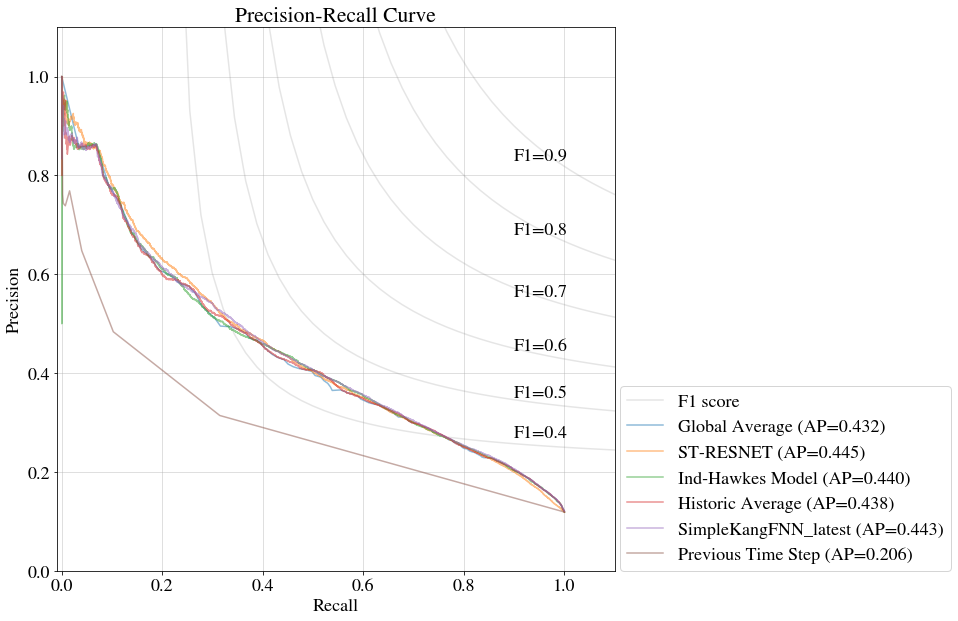

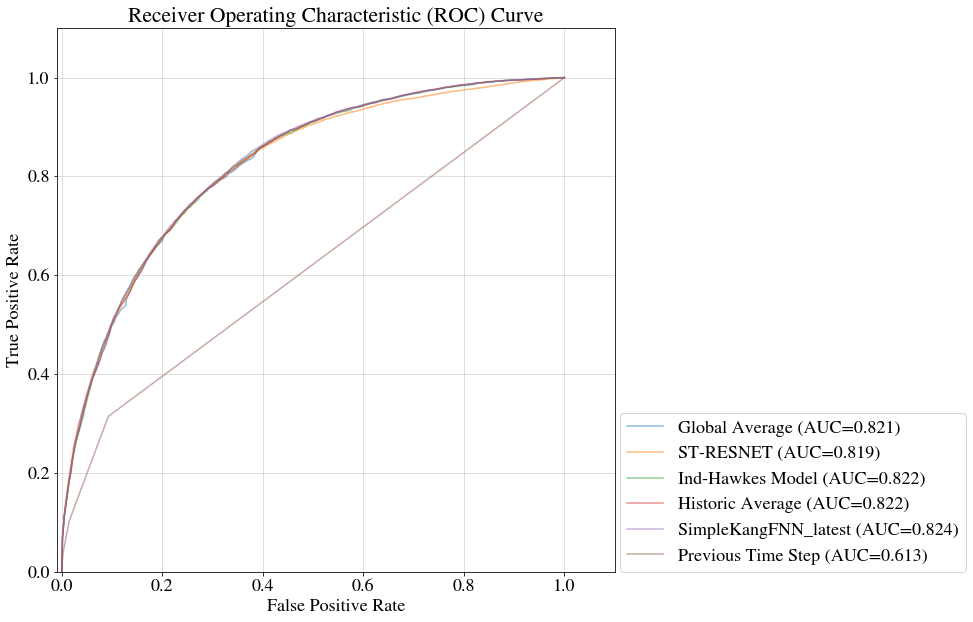

,RMSE,MAE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,MCC,PAI
Model Name,,,,,,,,,,
ST-RESNET,0.353654,0.126232,0.820416,0.470513,0.406699,0.492086,0.445336,0.855018,0.363372,3.478815
SimpleKangFNN_latest,0.596600,0.356383,0.824826,0.470280,0.392020,0.525238,0.448955,0.847078,0.366079,3.334029
Historic Average,0.352860,0.125658,0.824147,0.468529,0.403431,0.510700,0.450772,0.852260,0.368615,3.416103
Ind-Hawkes Model,0.382821,0.147177,0.824078,0.467860,0.424199,0.471722,0.446700,0.861322,0.366871,3.599641
Global Average,0.352786,0.125609,0.822889,0.466622,0.406593,0.489328,0.444141,0.854513,0.361800,3.441610
Previous Time Step,0.353081,0.125817,0.612782,0.223152,0.312110,0.312984,0.312546,0.836870,0.218475,2.648448


In [118]:
compare_all_models(data_path=conf.data_path)

-----

## All in one code

In [ ]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN

from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model

from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred

In [ ]:
data_sub_paths = os.listdir("./data/processed/")
data_sub_paths

In [ ]:
data_sub_paths = ['T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97']

In [ ]:

# data_dim_str = "T24H-X255M-Y220M"#"T24H-X850M-Y880M" # "T24H-X85M-Y110M" #"T1H-X1700M-Y1760M"  # needs to exist  
for data_sub_path in data_sub_paths:
    model_name = "Kang FNN"  # needs to be created    
    data_path = f"./data/processed/{data_sub_path}/"
    compare_all_models(data_path=data_path)

    if not os.path.exists(data_path):
        raise Exception(f"Directory ({data_path}) needs to exist.")

    model_path = data_path + f"models/{model_name}/"
    os.makedirs(data_path, exist_ok=True)
    os.makedirs(model_path, exist_ok=True)

    # logging config is set globally thus we only need to call this in this file
    # imported function logs will follow the configuration
    setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    timer = Timer()
    # manually set the config
    conf_dict = {
        "seed": 3,
        "use_cuda": True,
        
        "use_crime_types": False,
        
        # data group/data set related
        "val_ratio": 0.1,  # ratio of the total dataset
        "tst_ratio": 0.3,# ratio of the total dataset
        "seq_len": 1,
        "flatten_grid": True,  # if the shaper should be used to squeeze the data
        
        # shaper related 
        "shaper_top_k": -1,  # if less then 0, top_k will not be applied
        "shaper_threshold": 0,

        
        # data loader related
        "sub_sample_train_set": 1,
        "sub_sample_validation_set": 1,
        "sub_sample_validation_set": 0,
        
        # training parameters
        "resume": False,
        "early_stopping": False,
        "tolerance": 1e-8,
        "lr": 1e-3,
        "weight_decay": 1e-8,
        "max_epochs": 1,
        "batch_size": 64,
        "dropout": 0.2,
        "shuffle": False,
        "num_workers": 6,
        
        # attached global variables - bad practice -find alternative
        "device": None,  # pytorch device object [CPU|GPU]
        "timer": Timer(),
        "model_name": model_name,
        "model_path": model_path,
        "checkpoint": "best",

        "pad_width": 0,
        
        "use_seq_loss": True,
        "use_classification": True,
        "use_historic_average": True,
    }
    conf = BaseConf(conf_dict=conf_dict)

    info = deepcopy(conf.__dict__)
    info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.cuda.manual_seed( conf.seed)
    else:
        torch.manual_seed(conf.seed)

    device = torch.device("cuda:0" if use_cuda else "cpu")
    log.info(f"Device: {device}")
    info["device"] = device.type
    conf.device = device

    log.getLogger().setLevel("INFO")

    # SET THE HYPER PARAMETERS
    conf.resume = False
    conf.early_stopping = False
    conf.max_epochs = 1
    conf.dropout = 0#0.2
    conf.weight_decay = 1e-8
    conf.checkpoint = "best" # ["best"|"latest"]
    conf.lr = 5e-4
    conf.shaper_top_k = -1
    conf.batch_size =  256

    MOCK = False

    if MOCK:
        # MOCK THE DATA
        vector_size= [5,5,5]#[37,65,512]    
        class_split=0.5
        train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
        validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
        test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
        loaders = MockLoaders(train_loader,validation_loader,test_loader)
    else:
        # CRIME DATA
        conf.sub_sample_test_set = False
        conf.sub_sample_train_set = True
        conf.sub_sample_validation_set = True

        data_group = FlatDataGroup(data_path=data_path, conf=conf)
        loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    conf.freqstr = data_group.t_range.freqstr    

    # SET LOSS FUNCTION
    # size averaged - so more epochs or larger lr for smaller batches
    loss_function = nn.CrossEntropyLoss()  

    # SETUP MODEL
    train_set = loaders.train_loader.dataset
    indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
    spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


    model_arch = {
        "h_size0": 100,
        "h_size1": 100,
        "h_size2": 100,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                        tmp_size=tmp_size,
                        env_size=env_size,
                        dropout_p=conf.dropout,
                        model_arch=model_arch)

    # model_arch = {
    #     "scp_net_h0": 64,
    #     "scp_net_h1": 32,
    #     "tmp_net_h0": 64,
    #     "tmp_net_h1": 32,
    #     "env_net_h0": 64,
    #     "env_net_h1": 32,
    #     "final_net_h1": 64,
    # }
    # model = KangFeedForwardNetwork(spc_size=spc_size,
    #                                  tmp_size=tmp_size,
    #                                  env_size=env_size,
    #                                  dropout_p=conf.dropout,
    #                                  model_arch=model_arch)

    model.to(conf.device)

    # SETUP OPTIMISER
    parameters = model.parameters()

    # important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
    # - use gradient clipping instead
    optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

    ##### RESUME LOGIC
    if conf.resume:  # todo check if the files actually exist
        try:
            # resume from previous check point or resume from best validaton score checkpoint
            # load model state
            model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
            model.load_state_dict(model_state_dict)
            
            # load optimiser state
            optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                            map_location=conf.device.type)
            optimiser.load_state_dict(optimiser_state_dict) 

            # new optimiser hyper-parameters
            optimiser.param_groups[0]['lr'] = conf.lr
            optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            # new model hyper-parameters
            model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

        except Exception as e:
            log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                        optimiser=optimiser,
                                                                        loaders=loaders,
                                                                        train_epoch_fn=train_epoch_for_fnn,
                                                                        loss_fn=loss_function,
                                                                        conf=conf)    

    print(f"stopped_early: {stopped_early}") # use the current epoch instead
    # if stopped_early -> continue with best_model - new hyper-parameters -> no n 

    # Load latest or best validation model
    # conf.checkpoint = "best"
    conf.checkpoint = "best"

    log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

    # resume from previous check point or resume from best validaton score checkpoint
    # load model state
    model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                    map_location=conf.device.type)
    model.load_state_dict(model_state_dict)


    conf.sub_sample_test_set = False
    conf.sub_sample_train_set = False
    conf.sub_sample_validation_set = False

    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    def evaluate_fnn(model, batch_loader, conf):    
        """
        Only used to get probas in a time and location based format. The hard predictions should be done outside 
        this function where the threshold is determined using only the training data
        """
        probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)
        y_true = batch_loader.dataset.targets[-len(probas_pred):]
        t_range = batch_loader.dataset.t_range[-len(probas_pred):]
        
        
        with torch.set_grad_enabled(False):
            model.eval()
                
            num_batches = batch_loader.num_batches
            for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
                current_batch = batch_loader.current_batch

                # Transfer to PyTorch Tensor and GPU
                spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
                tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
                env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
                targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
                out = model(spc_feats, tmp_feats, env_feats)

                batch_probas_pred = F.softmax(out,dim=-1)[:,1].cpu().numpy() # select class1 prediction
                
                for i, p in zip(indices,batch_probas_pred):
                    n,c,l = i   
                    probas_pred[n,c,l] = p

        
        return y_true, probas_pred, t_range


    # todo set the train_loader to eval so that it does not subsample
    trn_y_true, trn_probas_pred, trn_t_range = evaluate_fnn(model=model,
                                                            batch_loader=loaders.train_loader,
                                                            conf=conf)

    thresh = best_threshold(y_true=trn_y_true,
                        probas_pred=trn_probas_pred)

    tst_y_true, tst_probas_pred, tst_t_range = evaluate_fnn(model=model,
                                                            batch_loader=loaders.test_loader,
                                                            conf=conf)    
        
        

    tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
        
        
    save_metrics(y_true=tst_y_true,
                y_pred=tst_y_pred,
                probas_pred=tst_probas_pred,
                t_range=tst_t_range,
                shaper=data_group.shaper,                
                conf=conf)   

    compare_all_models(data_path=data_path)

In [ ]:
from time import sleep
timer = Timer()
timer.reset()
i = 0
for v in loaders.train_loader:
    i += 1
print(f"i: {i} and train loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.validation_loader:
    i += 1
print(f"i: {i} and val loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.test_loader:
    i += 1
print(f"i: {i} and test loader time {timer.check()}")    

In [ ]:
from sklearn.metrics import precision_recall_curve


def safe_f1_score(pr):
    p, r = pr
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)

precision, recall, thresholds = precision_recall_curve(trn_y_true.flatten(), trn_probas_pred.flatten())
precision, recall, thresholds = precision_recall_curve(tst_y_true.flatten(), tst_probas_pred.flatten())
scores = np.array(list(map(safe_f1_score, zip(precision, recall))))
index_array = np.argmax(scores)  # almost always a singular int, and not an array

In [ ]:
plt.plot(scores)
plt.scatter(index_array,scores[index_array])
plt.show()

plt.plot(recall, precision)
plt.scatter(recall, precision, s=scores*5,alpha=.1)
plt.show()

**Metrics per cell**

In [ ]:
print("ap_per_cell\n")
ap_per_cell = average_precision_score_per_cell(tst_y_true, tst_probas_pred)
ap_per_cell = np.nan_to_num(ap_per_cell)
ap_per_cell = data_group.shaper.unsqueeze(ap_per_cell)[0,0]
im(ap_per_cell)

print("roc_per_cell\n")
roc_per_cell = roc_auc_score_per_cell(tst_y_true, tst_probas_pred)
roc_per_cell = np.nan_to_num(roc_per_cell)
roc_per_cell = data_group.shaper.unsqueeze(roc_per_cell)[0,0]
im(roc_per_cell)

print("p_per_cell\n")
p_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
p_per_cell = data_group.shaper.unsqueeze(p_per_cell)[0,0]
im(p_per_cell)

print("r_per_cell\n")
r_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
r_per_cell = data_group.shaper.unsqueeze(r_per_cell)[0,0]
im(r_per_cell)

**Metrics per time slot**: should be one plot per metric - with multiple models

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
freqstr = data_group.t_range.freqstr

N = tst_y_true.shape[0]

ap_per_time = average_precision_score_per_time_slot(y_true=tst_y_true,
                                                    probas_pred=tst_probas_pred)

ap_per_time = np.nan_to_num(ap_per_time)

roc_per_time = roc_auc_score_per_time_slot(y_true=tst_y_true,
                                           probas_pred=tst_probas_pred)
roc_per_time = np.nan_to_num(roc_per_time)

acc_per_time = accuracy_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
acc_per_time = np.nan_to_num(acc_per_time)

p_per_time = precision_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
p_per_time = np.nan_to_num(p_per_time)

r_per_time = recall_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
r_per_time = np.nan_to_num(r_per_time)


plt.figure(figsize=(15,4))
plt.plot(acc_per_time[:,0,0],label="Accuracy")
plt.plot(roc_per_time[:,0,0],label="ROC-AUC")
plt.plot(ap_per_time[:,0,0],label="Average Precision")
plt.plot(p_per_time[:,0,0],label="Precision")
plt.plot(r_per_time[:,0,0],label="Recall")
plt.title("Metrics per time step")
plt.ylabel("Score")
plt.xlabel(f"Time (step={freqstr})")
plt.ylim([0,1])
# plt.xlim([0,N-1])
plt.yticks(np.arange(11)/10)



plt.legend()
plt.grid(True,alpha=0.5)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, accuracy_score

In [ ]:
im(data_group.shaper.unsqueeze(tst_probas_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_true)[40][0])
# im(data_group.shaper.unsqueeze(loaders.test_loader.dataset.targets)[40][0])

In [ ]:
loaders.test_loader.dataset.targets.shape

In [ ]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [ ]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)

In [ ]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(conf.device)
        tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        env_feats = torch.Tensor(env_feats).to(conf.device)
        targets = torch.LongTensor(targets).to(conf.device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
                        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

In [ ]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape